In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [2]:
conn_str = os.getenv("CRAIGGER_CONN")  # make sure the tunnel is open
engine = create_engine(conn_str)

In [55]:
df = pd.read_sql(
    """
    SELECT 
  "gaddress", 
  replace(
    replace(price, '$', ''), 
    ',', 
    ''
  ):: numeric AS current_rent, 
  "bedbath", 
  "NumOfBeds", 
  "NumOfBaths", 
  coalesce(
    nullif("SqftMain", ''), 
    '0.00'
  ):: numeric(10, 2) AS sqft, 
  "BaseValue_Year", 
  "CurrentRoll_BaseYear", 
  "CurrentRoll_LandValue" :: numeric + "CurrentRoll_ImpValue" :: numeric AS current_assessment 
FROM 
  "padmapper_ads" 
WHERE 
  "UseType" = 'Single Family Residence' 
  AND "SqftMain" IS NOT NULL 
  AND "NumOfBeds" != ''
  AND "NumOfBaths" != '';
""",
    con=engine,
)
df['rent_per_sqft'] = df['current_rent']/df['sqft']
df['assessment_per_sqft'] = df['current_assessment']/df['sqft']
df = df[df["assessment_per_sqft"] > 1]
df['assessment_to_rent_ratio'] = df['current_assessment']/df['current_rent']
df["years_held"] = df["CurrentRoll_BaseYear"].map(int) - df["BaseValue_Year"].map(int)
df = df.drop_duplicates().dropna()
df.shape
df

gaddress  current_rent  \
0             458 Geneva Ave, Claremont, CA 91711, USA        2950.0   
1    526 Floral Park Terrace, S Pasadena, CA 91030,...        5500.0   
2     10045 W Chardonnay Ct, Sun Valley, CA 91352, USA        4800.0   
3        6627 Birchton Ave, Canoga Park, CA 91307, USA        6350.0   
4          17328 Keswick St, Northridge, CA 91325, USA        4800.0   
..                                                 ...           ...   
101        3129 Trousdale Dr, Lancaster, CA 93536, USA        2800.0   
102       24600 Skyline View Dr, Malibu, CA 90265, USA       17750.0   
103            1930 W 154th St, Gardena, CA 90249, USA        4150.0   
104    1743 Vista Del Valle Dr, Arcadia, CA 91006, USA        5000.0   
105          14803 Biola Ave, La Mirada, CA 90638, USA        3800.0   

                      bedbath NumOfBeds NumOfBaths    sqft BaseValue_Year  \
0    3 Bedrooms · 2 Bathrooms         3          2  1489.0           2002   
1     3 Bedrooms · 1 Bathroom         2          2  1575.0           2007   
2    4 Bedrooms · 3 Bathrooms         3          3  2392.0           2002   
3    4 Bedrooms · 2 Bathrooms         4          2  1570.0           2010   
4    4 Bedrooms · 3 Bathrooms         3          2  1621.0           1981   
..                        ...       ...        ...     ...            ...   
101  4 Bedrooms · 3 Bathrooms         4          3  2496.0           2014   
102  4 Bedrooms · 4 Bathrooms         3          3  4395.0           1991   
103  4 Bedrooms · 3 Bathrooms         4          2  1575.0           2021   
104  4 Bedrooms · 4 Bathrooms         4          4  2800.0           2003   
105  3 Bedrooms · 2 Bathrooms         3          2  1311.0           2004   

    CurrentRoll_BaseYear  current_assessment  rent_per_sqft  \
0                   2022            269809.0       1.981195   
1                   2022           1069336.0       3.492063   
2                   2022            531483.0       2.006689   
3                   2022            583847.0       4.044586   
4                   2022            229484.0       2.961135   
..                   ...                 ...            ...   
101                 2022            306683.0       1.121795   
102                 2022           1925640.0       4.038680   
103                 2022            747660.0       2.634921   
104                 2022            937598.0       1.785714   
105                 2022            542598.0       2.898551   

     assessment_per_sqft  assessment_to_rent_ratio  years_held  
0             181.201478                 91.460678          20  
1             678.943492                194.424727          15  
2             222.191890                110.725625          20  
3             371.877070                 91.944409          12  
4             141.569402                 47.809167          41  
..                   ...                       ...         ...  
101           122.869792                109.529643           8  
102           438.143345                108.486761          31  
103           474.704762                180.159036           1  
104           334.856429                187.519600          19  
105           413.881007                142.788947          18  

[70 rows x 13 columns]

(459, 21)

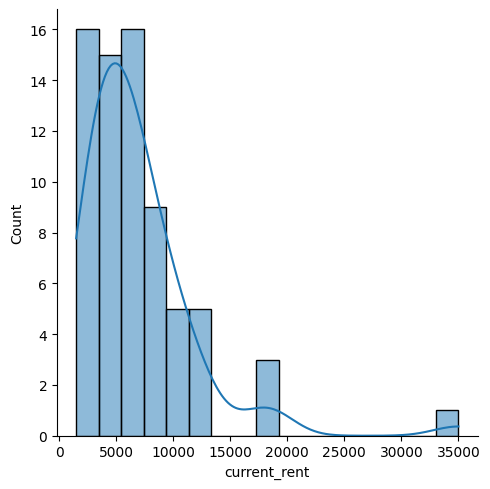

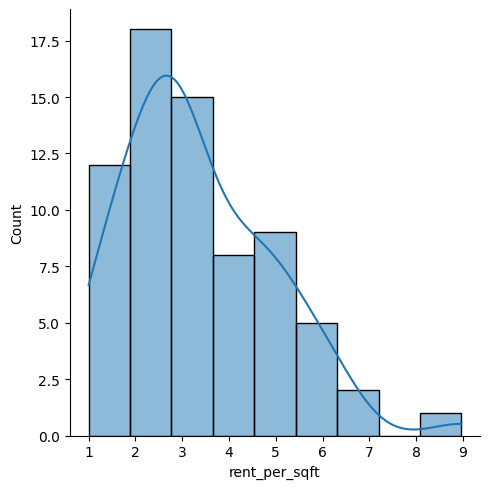

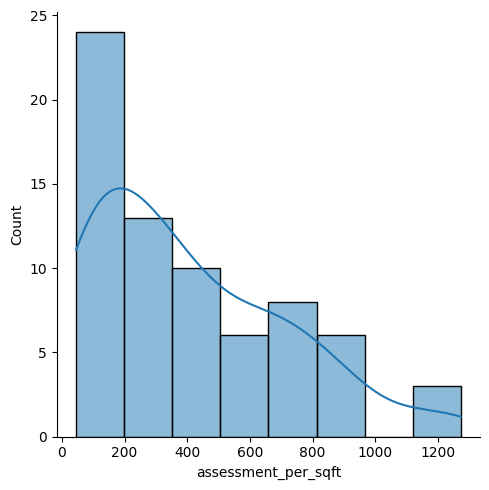

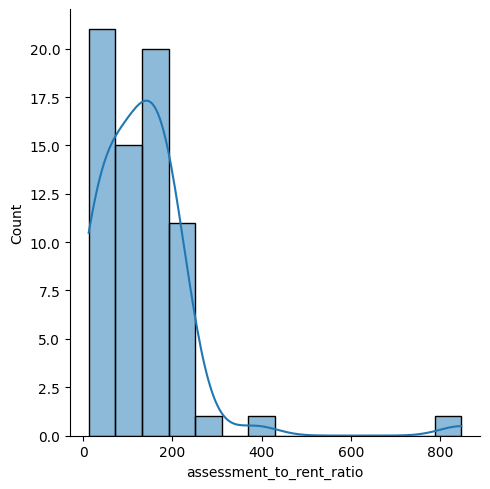

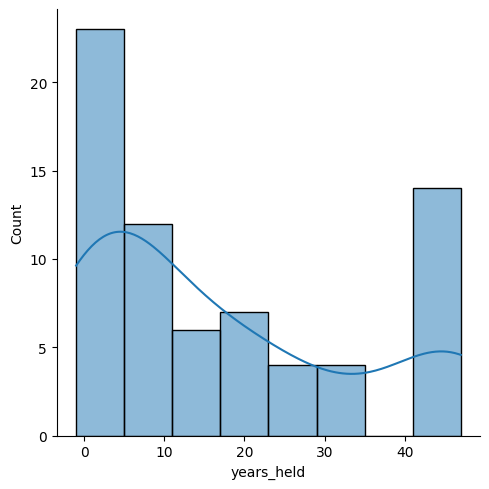

In [56]:
# loop through each column and plot a displot
for column in [
    "current_rent",
    "rent_per_sqft",
    "assessment_per_sqft",
    "assessment_to_rent_ratio",
    "years_held",
]:
    sns.displot(df[column], kde=True)

Text(0.5, 1.04, 'Tax Assesment per sqft vs Rent per sqft in Los Angeles')

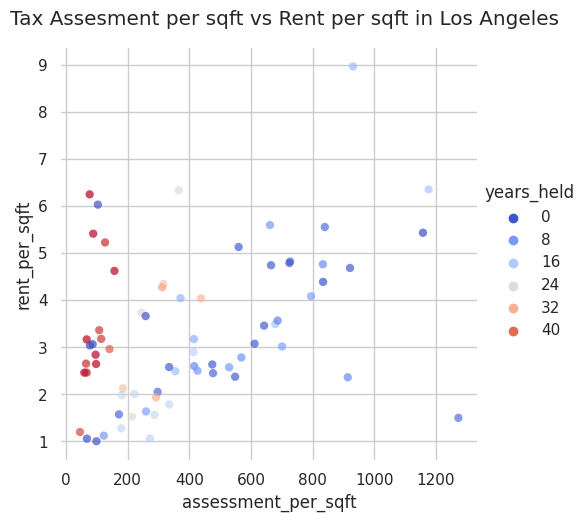

In [58]:
sns.set_theme(style="whitegrid")

cmap = sns.color_palette("coolwarm", as_cmap=True)
# cmap = sns.color_palette("flare", as_cmap=True)
# cmap = sns.color_palette("dark:salmon_r", as_cmap=True)

g = sns.relplot(
    data=df,
    x="assessment_per_sqft",
    y="rent_per_sqft",
    hue="years_held",
    linewidth=0,
    alpha=0.7,
    palette=cmap,
)
g.despine(left=True, bottom=True)
plt.suptitle("Tax Assesment per sqft vs Rent per sqft in Los Angeles", y=1.04)

In [7]:
df[
    [
        "gAddress",
        "zip",
        "post_date",
        "NumOfBeds",
        "SqftMain",
        "BaseValue_Year",
        "rent_per_sqft",
        "assesment_per_sqft",
        "assesment_to_rent_ratio",
    ]
]

gAddress    zip   post_date  \
0     7143 Woodrow Wilson Dr, Los Angeles, CA 90068,...  90068  2022-02-24   
2              7233 9th Ave, Los Angeles, CA 90043, USA  90043  2022-02-20   
4         3744 Mayland Ave, Baldwin Park, CA 91706, USA  91706  2022-03-07   
8            16927 Casimir Ave, Torrance, CA 90504, USA  90504  2021-05-12   
10           2052 W 77th St, Los Angeles, CA 90047, USA  90047  2022-01-20   
...                                                 ...    ...         ...   
1324           6656 7th Ave, Los Angeles, CA 90043, USA  90043  2021-03-14   
1327        5811 E Rogene St, Long Beach, CA 90815, USA  90815  2020-11-14   
1329        843 Maltman Ave, Los Angeles, CA 90026, USA  90026  2022-01-26   
1332       1107 Maple St, South Pasadena, CA 91030, USA  91030  2021-02-18   
1333         8504 Walnut Dr, Los Angeles, CA 90046, USA  90046  2020-12-17   

     NumOfBeds SqftMain BaseValue_Year  rent_per_sqft  assesment_per_sqft  \
0            1      825           2021       5.933333         1032.363636   
2            4     1649           2017       2.334748          284.517283   
4            3     1352           2017       1.664201          384.228550   
8            3     1276           2019       2.586207          469.568966   
10           3     1264           2020       3.435115          472.886076   
...        ...      ...            ...            ...                 ...   
1324         2      726           2021       3.030303          660.330579   
1327         2     1009           2021       0.996036          722.794846   
1329         1      640           2023       2.968750         1287.475000   
1332         3     1756           2013       2.562642          525.347380   
1333         2      859           2016       2.958333         1292.128056   

      assesment_to_rent_ratio  
0                  173.993871  
2                  121.862078  
4                  230.878667  
8                  181.566667  
10                 132.828444  
...                       ...  
1324               217.909091  
1327               725.671642  
1329               433.675789  
1332               205.002222  
1333               312.658592  

[459 rows x 9 columns]

In [8]:
df["zip"].value_counts()

90026    24
91801    14
90039    14
90068    12
90016    11
         ..
90254     1
91711     1
90713     1
90048     1
90057     1
Name: zip, Length: 145, dtype: int64